<a href="https://colab.research.google.com/github/sebaspv/PueblaFutureCovidCasesRNN/blob/master/PueblaRNNCovidCases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
#data source = https://coronavirus.gob.mx/datos/#DOView


In [2]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
data_dir = '/content/gdrive/My Drive'

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [33]:
daily_cases = pd.read_csv(data_dir+'/Casos_Diarios_Estado_Nacional_Confirmados_20200913.csv')

In [34]:
daily_cases = daily_cases.transpose()
daily_cases

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
cve_ent,1,2,3,4,7,8,9,5,6,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,0
poblacion,1434635,3634868,804708,1000617,5730367,3801487,9018645,3218720,785153,1868996,6228175,3657048,3086414,8409693,17427790,4825401,2044058,1288571,5610153,4143593,6604451,2279637,1723259,2866142,3156674,3074745,2572287,3650602,1380011,8539862,2259098,1666426,127792286
nombre,AGUASCALIENTES,BAJA CALIFORNIA,BAJA CALIFORNIA SUR,CAMPECHE,CHIAPAS,CHIHUAHUA,DISTRITO FEDERAL,COAHUILA,COLIMA,DURANGO,GUANAJUATO,GUERRERO,HIDALGO,JALISCO,MEXICO,MICHOACAN,MORELOS,NAYARIT,NUEVO LEON,OAXACA,PUEBLA,QUERETARO,QUINTANA ROO,SAN LUIS POTOSI,SINALOA,SONORA,TABASCO,TAMAULIPAS,TLAXCALA,VERACRUZ,YUCATAN,ZACATECAS,Nacional
12-01-2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13-01-2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
08-09-2020,51,35,122,12,4,7,813,190,36,104,379,130,64,271,244,211,18,38,462,97,125,85,69,154,81,100,133,125,16,140,174,78,4568
09-09-2020,47,27,85,11,6,9,584,87,27,85,305,104,79,229,194,111,18,35,424,73,100,76,47,110,51,71,74,82,14,101,145,75,3486
10-09-2020,11,13,68,9,15,5,193,70,22,58,249,24,54,160,87,27,20,31,189,36,59,52,43,22,19,2,108,63,19,18,137,104,1987
11-09-2020,0,6,52,14,5,0,62,57,22,57,19,5,40,101,27,0,3,11,108,25,27,61,24,6,14,2,84,23,11,4,107,79,1056


In [35]:
daily_cases.columns = daily_cases.iloc[2]

In [36]:
daily_cases = daily_cases.drop('cve_ent')

In [37]:
daily_cases = daily_cases.drop('poblacion')
daily_cases = daily_cases.drop('nombre')

In [38]:
puebla_cases = daily_cases['PUEBLA']

In [39]:
index = []
for i in range(len(puebla_cases.index)):
  index.append(i)
  i+=1
len(index)
#create new index

245

In [40]:
daily_cases

nombre,AGUASCALIENTES,BAJA CALIFORNIA,BAJA CALIFORNIA SUR,CAMPECHE,CHIAPAS,CHIHUAHUA,DISTRITO FEDERAL,COAHUILA,COLIMA,DURANGO,GUANAJUATO,GUERRERO,HIDALGO,JALISCO,MEXICO,MICHOACAN,MORELOS,NAYARIT,NUEVO LEON,OAXACA,PUEBLA,QUERETARO,QUINTANA ROO,SAN LUIS POTOSI,SINALOA,SONORA,TABASCO,TAMAULIPAS,TLAXCALA,VERACRUZ,YUCATAN,ZACATECAS,Nacional
12-01-2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13-01-2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
14-01-2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15-01-2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16-01-2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
08-09-2020,51,35,122,12,4,7,813,190,36,104,379,130,64,271,244,211,18,38,462,97,125,85,69,154,81,100,133,125,16,140,174,78,4568
09-09-2020,47,27,85,11,6,9,584,87,27,85,305,104,79,229,194,111,18,35,424,73,100,76,47,110,51,71,74,82,14,101,145,75,3486
10-09-2020,11,13,68,9,15,5,193,70,22,58,249,24,54,160,87,27,20,31,189,36,59,52,43,22,19,2,108,63,19,18,137,104,1987
11-09-2020,0,6,52,14,5,0,62,57,22,57,19,5,40,101,27,0,3,11,108,25,27,61,24,6,14,2,84,23,11,4,107,79,1056


In [41]:
puebla_cases.index = index

In [42]:
total_cases = []
n = 0
for i in puebla_cases:
  n+=i
  total_cases.append(n)
len(total_cases)

245

In [43]:
puebla_cases = total_cases

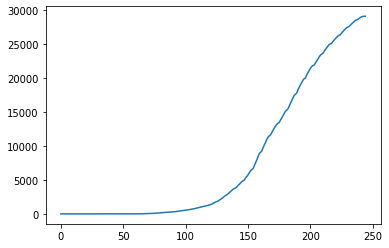

In [44]:
plt.plot(puebla_cases)

In [45]:
test_point = np.round(len(puebla_cases)*.1) #Pasamos el 10% de nuestra información para probar nuestro modelo
test_point

24.0

In [46]:
test_ind = int(len(puebla_cases) - test_point)

In [47]:
train = puebla_cases[:test_ind]
test = puebla_cases[test_ind:]
#Dividimos train y test data

In [48]:
from sklearn.preprocessing import MinMaxScaler

In [49]:
scaler = MinMaxScaler()

In [50]:
scaler.fit(np.reshape(train,(221,1)))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [51]:
scaled_train = scaler.transform(np.reshape(train,(221,1)))
scaled_test = scaler.transform(np.reshape(test,(24,1)))

In [52]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [53]:
length_of_pred = 20 #Datos que se tomarán para predecir valor futuro
batch_size = 1 #Cantidades a predecir

In [54]:
generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length=length_of_pred,batch_size=1)


validation_generator = TimeseriesGenerator(scaled_test,scaled_test,
                                          length=length_of_pred,batch_size=1)

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SimpleRNN, LSTM

In [56]:
n_features = 1

In [57]:
model = Sequential()
model.add(LSTM(100,input_shape=(length_of_pred,n_features),return_sequences=True))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [58]:
from tensorflow.keras.callbacks import EarlyStopping

In [59]:
early_stop = EarlyStopping(monitor='val_loss',patience=0)

In [60]:
model.fit(generator,epochs=10,
                   validation_data=validation_generator,
                   callbacks=[early_stop])
#Entrenamos el modelo

Epoch 1/10
201/201 [==============================] - 4s 21ms/step - loss: 0.0187 - val_loss: 0.0038
Epoch 2/10
201/201 [==============================] - 3s 12ms/step - loss: 0.0011 - val_loss: 0.0501


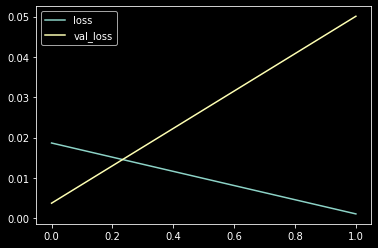

In [61]:
plt.style.use('dark_background')
losses = pd.DataFrame(model.history.history)
losses.plot() #Vemos como bajó el error de nuestro modelo durante el entrenamiento

In [62]:
test_predictions = []

first_eval_batch = scaled_train[-length_of_pred:]
current_batch = first_eval_batch.reshape((1, length_of_pred, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    #Creamos la lista con las predicciones de nuestro modelo

In [63]:
true_predictions = scaler.inverse_transform(test_predictions)
predicciones = pd.DataFrame(test)

In [64]:
predicciones.columns = ['Predicciones Verdaderas']

In [65]:
predicciones['Predicción de Modelo'] = true_predictions

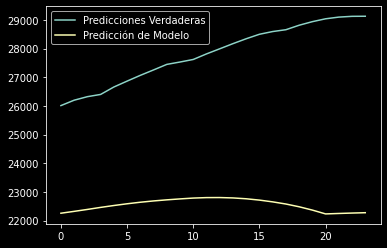

In [66]:
predicciones.plot()